## U-Net

In [14]:
import torch
from torch import nn
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO

In [2]:
## ConvBlock
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),  ## padding=1 keep input and output have same height and width
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        )
    
    def forward(self, x):
        return self.convs(x)

In [ ]:
## U-Net
class UNet(nn.Module):
    def __init__(self, in_ch=1):
        super().__init__()
        self.down1=ConvBlock(in_ch, 64)
        self.down2=ConvBlock(64, 128)
        self.bot1=ConvBlock(128, 256)  ## deeper squeeze
        self.up2=ConvBlock(128+256, 128)  ## concatenate with down2 in dim1
        self.up1=ConvBlock(128+64, 64)  ## concatenate with down1 in dim1
        self.out=nn.Conv2d(64, in_ch, 1)

        self.maxpool=nn.MaxPool2d(2)  
        self.upsample=nn.Upsample(scale_factor=2, mode="bilinear")  ## twice as before
    
    def forward(self, x):
        x1=self.down1(x)
        x=self.maxpool(x1)
        x2=self.down2(x)
        x=self.maxpool(x2)
        x=self.bot1(x)

        x=self.upsample(x)
        x=torch.cat([x, x2], dim=1)
        x=self.up2(x)
        x=self.upsample(x)
        x=torch.cat([x, x1], dim=1)
        x=self.up1(x)
        x=self.out(x)

        return x

In [4]:
## using random data for demo
model=UNet()
x=torch.randn(10, 1, 28, 28)
y=model(x)
print(y.shape)

torch.Size([10, 1, 28, 28])


## 正弦位置编码

In [5]:
def _pos_encoding(t, output_dim, device='cpu'):
    D = output_dim
    v = torch.zeros(D, device=device)
    i = torch.arange(0, D, device=device)
    div_term = 10000 * (i / D)

    v[0::2] = torch.sin(t / div_term[0::2])
    v[1::2] = torch.cos(t / div_term[1::2])
    return v

In [6]:
v = _pos_encoding(1, 16) # input is 1, output dim is 16
print(v.shape)

torch.Size([16])


In [7]:
## batch position encoding
def pos_encoding(ts, output_dim, device='cpu'):
    batch_size = len(ts)
    v = torch.zeros(batch_size, output_dim, device=device)
    for i in range(batch_size):
        v[i] = _pos_encoding(ts[i], output_dim, device)
    return v

In [8]:
v = pos_encoding(torch.tensor([1,2,3]), 16)
print(v.shape)

torch.Size([3, 16])


In [9]:
## add position information into the ConvBlock
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_embed_dim):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),  ## padding=1 keep input and output have same height and width
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        )

        self.mlp = nn.Sequential(
            nn.Linear(time_embed_dim, in_ch),
            nn.ReLU(),
            nn.Linear(in_ch, in_ch)
        )

    def forward(self, x, v):
        N, C, _, _ = x.shape
        v = self.mlp(v)
        v = v.view(N, C, 1, 1) # reshape (N,C) into (N,C,1,1)
        y = self.convs(x + v)
        return y

In [10]:
class UNet(nn.Module):
    def __init__(self, in_ch = 1, time_embed_dim = 100):
        super().__init__()
        self.time_embed_dim = time_embed_dim

        self.down1=ConvBlock(in_ch, 64, time_embed_dim)
        self.down2=ConvBlock(64, 128, time_embed_dim)
        self.bot1=ConvBlock(128, 256, time_embed_dim)  ## deeper squeeze
        self.up2=ConvBlock(128+256, 128, time_embed_dim)  ## concatenate with down2 in dim1
        self.up1=ConvBlock(128+64, 64, time_embed_dim)  ## concatenate with down1 in dim1
        self.out=nn.Conv2d(64, in_ch, 1)

        self.maxpool=nn.MaxPool2d(2)  
        self.upsample=nn.Upsample(scale_factor=2, mode="bilinear")  ## twice as before
    
    def forward(self, x, timesteps):
        ## sin position encoding
        v = pos_encoding(timesteps, self.time_embed_dim, x.device)
        x1=self.down1(x, v)
        x=self.maxpool(x1)
        x2=self.down2(x, v)
        x=self.maxpool(x2)
        x=self.bot1(x, v)

        x=self.upsample(x)
        x=torch.cat([x, x2], dim=1)
        x=self.up2(x)
        x=self.upsample(x)
        x=torch.cat([x, x1], dim=1)
        x=self.up1(x)
        x=self.out(x)
    
        return x

## 扩散过程
基于q(xt|xt-1)采样

In [11]:
x = torch.randn(3, 64, 64)
T = 1000
betas = torch.linspace(0.0001, 0.02, T)

for t in range(T):
    beta = betas[t]
    eps = torch.rand_like(x)
    res = torch.sqrt(1 - beta) * x + torch.sqrt(beta) * eps

(276, 183, 3)


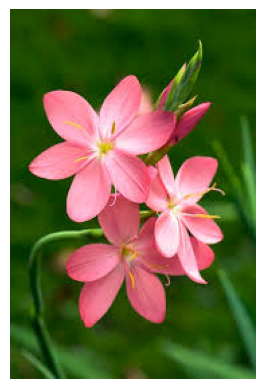

torch.Size([3, 276, 183])


In [29]:
## diffusion process of image
# load img
file_path = "./flower.png"
image = Image.open(file_path).convert("RGB")
image_array = np.array(image)
print(image_array.shape)

plt.imshow(image_array)
plt.axis('off')
plt.show()

## transform
transform = transforms.ToTensor()
x = transform(image)
print(x.shape)

In [25]:
## reverse
def reverse_to_img(x):
    x = x * 255
    x = x.clamp(0, 255)
    x = x.to(torch.uint8)
    to_pil = transforms.ToPILImage()
    return to_pil(x)

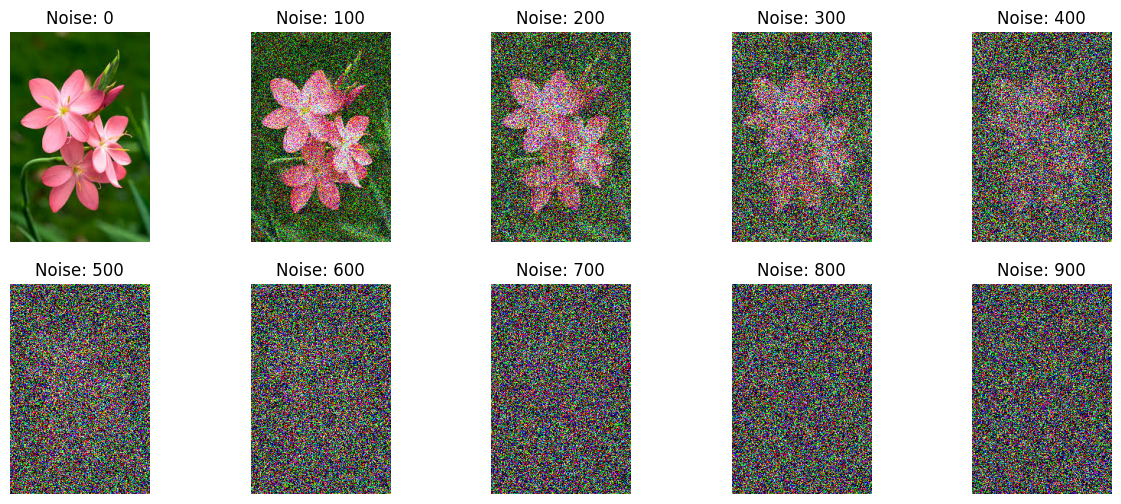

In [30]:
## diffusion process
T = 1000
beta_start = 0.0001
beta_end = 0.02
betas = torch.linspace(beta_start, beta_end, T)
imgs = []

for t in range(T):
    if t % 100 == 0:
        img = reverse_to_img(x)
        imgs.append(img)
    
    beta = betas[t]
    eps = torch.randn_like(x)
    x = torch.sqrt(1 - beta) * x + torch.sqrt(beta) * eps

plt.figure(figsize=(15, 6))
for i, img in enumerate(imgs[:10]):
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title(f'Noise: {i * 100}')
    plt.axis('off')

plt.show()